# アンサンブル学習:  勾配ブースティング

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.datasets import load_iris, make_moons
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingRegressor
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

warnings.filterwarnings('ignore')


%matplotlib inline

## Data Preparation

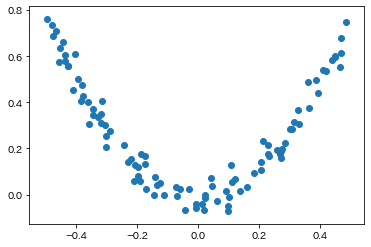

In [2]:
np.random.seed(42)

X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

plt.scatter(X, y)

## 手動で勾配ブースティングをやってみる

### 予測器1

In [3]:
# 予測器1を訓練
reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)

reg1.fit(X, y)

reg1.score(X, y)

0.761166774760411

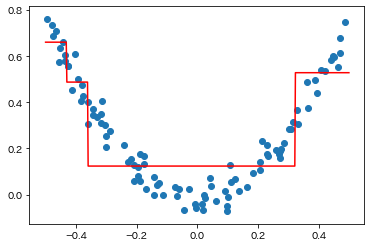

In [4]:
# 現在の予測(予測器1だけのアンサンブル)
plt.scatter(X, y)

x_line = np.linspace(start=-0.5, stop=0.5, num=500).reshape(-1, 1)
plt.plot(x_line, reg1.predict(x_line), c='r')

### 予測器2

In [5]:
# 「予測器1が作った残差」を使って予測器2を訓練
y2 = y - reg1.predict(X)

reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
reg2.fit(X, y2)

reg2.score(X, y2)

0.5382185780832865

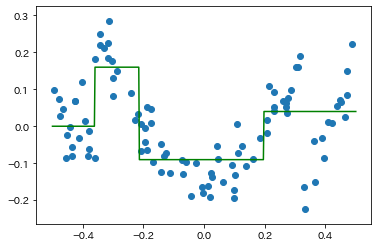

In [6]:
# 予測器2の、残差に対する予測
plt.scatter(X, y2)

x_line = np.linspace(start=-0.5, stop=0.5, num=500).reshape(-1, 1)
plt.plot(x_line, reg2.predict(x_line), c='g')

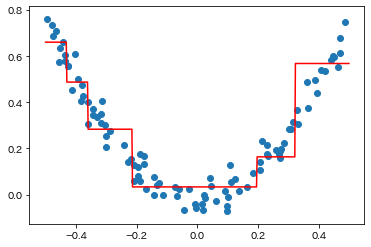

In [7]:
# 予測器1と予測器2のアンサンブル
plt.scatter(X, y)

x_line = np.linspace(start=-0.5, stop=0.5, num=500).reshape(-1, 1)
plt.plot(x_line, 
         reg1.predict(x_line) + reg2.predict(x_line),
         c='r')

### 予測器3

In [8]:
# 「予測器2が作った残差」を使って予測器3を訓練
y3 = y2 - reg2.predict(X)

reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
reg3.fit(X, y3)

reg3.score(X, y3)

0.17988245500564848

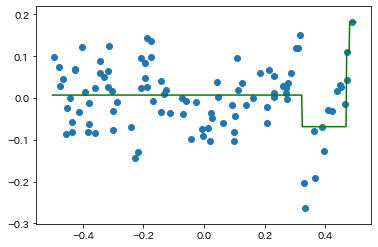

In [9]:
# 予測器3の、残差に対する予測
plt.scatter(X, y3)

x_line = np.linspace(start=-0.5, stop=0.5, num=500).reshape(-1, 1)
plt.plot(x_line, reg3.predict(x_line), c='g')

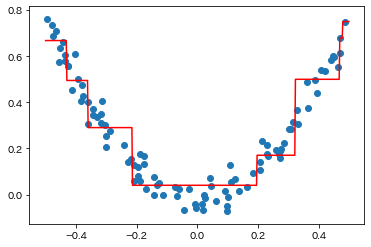

In [10]:
# 現在のアンサンブル
plt.scatter(X, y)

x_line = np.linspace(start=-0.5, stop=0.5, num=500).reshape(-1, 1)
plt.plot(x_line,
         reg1.predict(x_line) + reg2.predict(x_line)+reg3.predict(x_line),
         c='r')

### 手動の流れまとめ

'\n- アンサンブル(右列)はどんどん強くなっている\n\n\n'

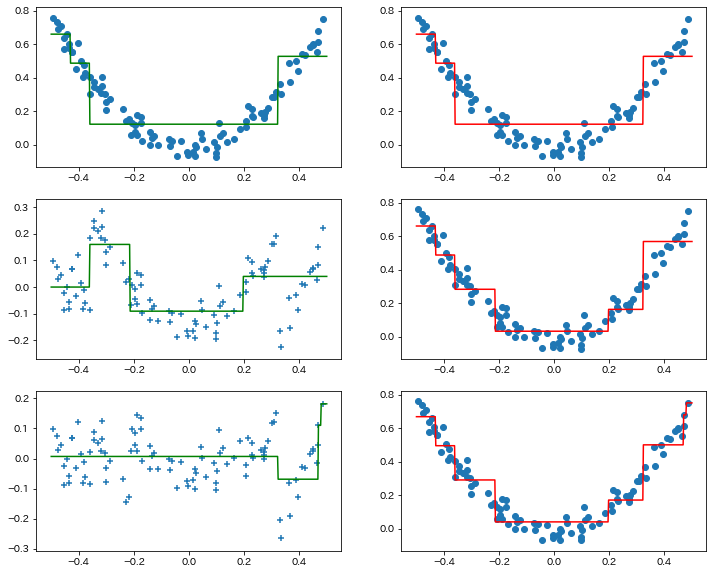

In [11]:
# TODO: Refactor
fig, axes = plt.subplots(3, 2, figsize=(12, 10))


x_line = np.linspace(start=-0.5, stop=0.5, num=500).reshape(-1, 1)


axes[0][0].scatter(X, y)
axes[0][0].plot(x_line,
                reg1.predict(x_line),
                c='g')

axes[1][0].scatter(X, y2, marker='+')
axes[1][0].plot(x_line,
                reg2.predict(x_line),
                c='g')

axes[2][0].scatter(X, y3, marker='+')
axes[2][0].plot(x_line,
                reg3.predict(x_line),
                c='g')


axes[0][1].scatter(X, y)
axes[0][1].plot(x_line,
                reg1.predict(x_line),
                c='r')

axes[1][1].scatter(X, y)
axes[1][1].plot(x_line,
                reg1.predict(x_line) + reg2.predict(x_line),
                c='r')

axes[2][1].scatter(X, y)
axes[2][1].plot(x_line,
                reg1.predict(x_line) + reg2.predict(x_line) + reg3.predict(x_line),
                c='r')

"""
- アンサンブル(右列)はどんどん強くなっている


"""

## GradientBoostingRegressorでつくる

### 同じもので作る

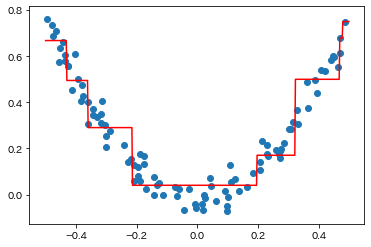

In [12]:
gbrt = GradientBoostingRegressor(max_depth=2,
                                 n_estimators=3,
                                 learning_rate=1.0)

gbrt.fit(X, y)


plt.scatter(X, y)

x_line = np.linspace(start=-0.5, stop=0.5, num=500).reshape(-1, 1)

plt.plot(x_line,
         gbrt.predict(x_line),
         c='r')

### 予測器が足りない / 予測器が多すぎる

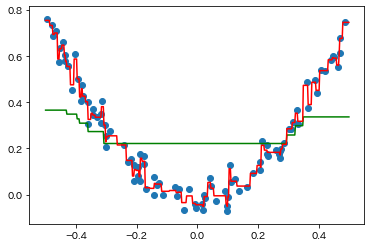

In [13]:
gbrt1 = GradientBoostingRegressor(max_depth=2,n_estimators=3,learning_rate=0.1)
gbrt1.fit(X, y)

gbrt2 = GradientBoostingRegressor(max_depth=2,n_estimators=300,learning_rate=0.1)
gbrt2.fit(X, y)


plt.scatter(X, y)

x_line = np.linspace(start=-0.5, stop=0.5, num=500).reshape(-1, 1)

plt.plot(x_line, gbrt1.predict(x_line), c='g')
plt.plot(x_line, gbrt2.predict(x_line), c='r')

## 予測器の数のパラメータチューニング
- 学習率を大きくすると、個々の決定木が強く補正を行おうとし、モデルは複雑になる。
- n_estimatorsを増やすことで、アンサンブル中の決定木の数を増やすと、訓練セットに対する過ちを補正する機会が増えるので、やはりモデルは複雑になる。

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X, y)

gbrt = GradientBoostingRegressor(max_depth=2,n_estimators=120)
gbrt.fit(X_train, y_train)

# staged_predict(X): 各アンサンブルの段階での予測のGeneratorを返す
errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
best_n_estimators = np.argmin(errors)

gbrt_best = GradientBoostingRegressor(max_depth=2,
                                      n_estimators=best_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=80,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Text(0.5, 1.0, 'Best GBRT(80 trees)')

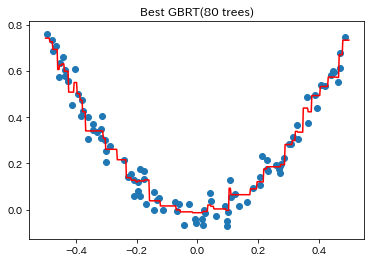

In [15]:
plt.scatter(X, y)

x_line = np.linspace(start=-0.5, stop=0.5, num=500).reshape(-1, 1)

plt.plot(x_line, gbrt_best.predict(x_line), c='r')
plt.title(f'Best GBRT({best_n_estimators} trees)')

Text(0.5, 1.0, 'Validation Error')

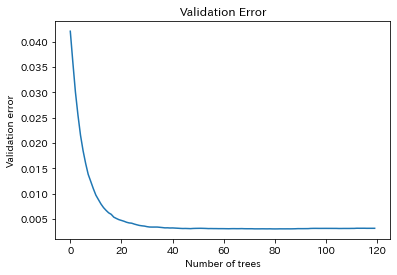

In [16]:
errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]

plt.plot(range(120), errors)
plt.xlabel('Number of trees')
plt.ylabel('Validation error')
plt.title('Validation Error')

## 早期打ち切りのオプション

In [17]:
# 検証誤差が5回連続で改善されない場合は訓練を打ち切る
gbrt = GradientBoostingRegressor(max_depth=2, 
                                 warm_start=True,
                                 loss='ls')

min_val_error = float('inf')
error_going_up = 0

for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    
    val_error = mean_squared_error(y_val, gbrt.predict(X_val))
    
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        
    if error_going_up == 5:
        break

## 勾配ブースティング vs ランダムフォレスト
### 特徴量の重要度
- 勾配ブースティング回帰木の特徴量重要度はランダムフォレストの特徴量重要度に似ているが、勾配ブースティングのほうでは、いくつかの特徴量が完全に無視されていることがわかる。

### 頑健さと予測精度
勾配ブースティングとランダムフォレストは、同じようなデータを得意とするので、一般には、ランダムフォレストを先に試した方がいい。こちらのほうが頑健だからだ。ランダムフォレストがうまく行ったとしても、予測時間が非常に重要な場合や、機械学習モデルから最後の1%まで性能を絞り出したい場合には勾配ブースティングを試してみるとよいだろう。

## XGBoostを試す

### sklearnAPIで単純に学習

[01:07:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


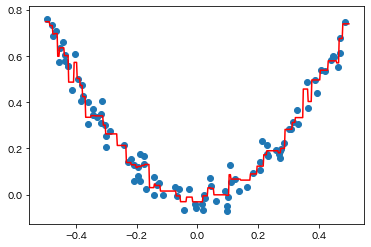

In [18]:
from xgboost import XGBRegressor

xgb = XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)


plt.scatter(X, y)

x_line = np.linspace(start=-0.5, stop=0.5, num=500).reshape(-1, 1)

plt.plot(x_line, xgb.predict(x_line), c='r')

### 早期打ち切り

In [19]:
# めちゃくちゃログを吐き出すので、自分用のLoggerを作ってファイル出力すると要約が見れて良い
xgb = XGBRegressor(random_state=42)
xgb.fit(X_train, 
        y_train,
        eval_set=[(X_val, y_val)], 
        early_stopping_rounds=2)

y_pred = xgb.predict(X_val)

val_error = mean_squared_error(y_val, y_pred)
print("Validation MSE:", val_error)

[01:07:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.293875
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.267065
[2]	validation_0-rmse:0.242576
[3]	validation_0-rmse:0.220742
[4]	validation_0-rmse:0.201331
[5]	validation_0-rmse:0.184459
[6]	validation_0-rmse:0.169273
[7]	validation_0-rmse:0.156736
[8]	validation_0-rmse:0.145655
[9]	validation_0-rmse:0.135922
[10]	validation_0-rmse:0.126495
[11]	validation_0-rmse:0.117748
[12]	validation_0-rmse:0.11018
[13]	validation_0-rmse:0.103422
[14]	validation_0-rmse:0.097701
[15]	validation_0-rmse:0.092833
[16]	validation_0-rmse:0.087878
[17]	validation_0-rmse:0.083645
[18]	validation_0-rmse:0.080181
[19]	validation_0-rmse:0.076976
[20]	validation_0-rmse:0.074096
[21]	validation_0-rmse:0.071598
[22]	validation_0-rmse:0.069392
[23]	validation_0-rmse:0.067381
[24]	validation_0-rmse:0.06567
[25]	validation_0-rmse:0.064365


## Memo
- [SVM: Weighted samples — scikit-learn 0.21.2 documentation](https://scikit-learn.org/stable/auto_examples/svm/plot_weighted_samples.html)


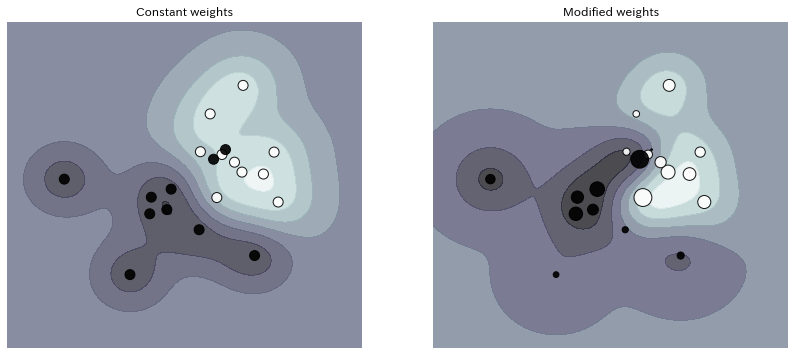

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm


def plot_decision_function(classifier, sample_weight, axis, title):
    # plot the decision function
    xx, yy = np.meshgrid(np.linspace(-4, 5, 500), np.linspace(-4, 5, 500))

    Z = classifier.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # plot the line, the points, and the nearest vectors to the plane
    axis.contourf(xx, yy, Z, alpha=0.75, cmap=plt.cm.bone)
    axis.scatter(X[:, 0], X[:, 1], c=y, s=100 * sample_weight, alpha=0.9,
                 cmap=plt.cm.bone, edgecolors='black')

    axis.axis('off')
    axis.set_title(title)


# we create 20 points
np.random.seed(0)
X = np.r_[np.random.randn(10, 2) + [1, 1], np.random.randn(10, 2)]
y = [1] * 10 + [-1] * 10
sample_weight_last_ten = abs(np.random.randn(len(X)))
sample_weight_constant = np.ones(len(X))
# and bigger weights to some outliers
sample_weight_last_ten[15:] *= 5
sample_weight_last_ten[9] *= 15

# for reference, first fit without sample weights

# fit the model
clf_weights = svm.SVC(gamma=1)
clf_weights.fit(X, y, sample_weight=sample_weight_last_ten)

clf_no_weights = svm.SVC(gamma=1)
clf_no_weights.fit(X, y)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_decision_function(clf_no_weights, sample_weight_constant, axes[0],
                       "Constant weights")
plot_decision_function(clf_weights, sample_weight_last_ten, axes[1],
                       "Modified weights")

plt.show()